# Request Type
Command vs Question

In [1]:
import pandas as pd
import sqlite3
import os
import numpy as np


from helpers.normalization import remove_punctuation, remove_punctuation_and_newlines, remove_newlines
from helpers.statistical_tests import run_t_test_on_gender, compare_genders

db_path = "../../giicg.db"
if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database file does not exist: {db_path}")

conn = sqlite3.connect(db_path)
prompts = pd.read_sql("SELECT ep.*, u.age, u.work_exp_years FROM filtered_prompts ep JOIN users u ON ep.user_id = u.user_id", conn)
prompts['conversational'] = prompts['conversational'].apply(remove_newlines)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set up LLM

In [12]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate

load_dotenv()

class OutputFormat(BaseModel):
    can_you_q: bool = Field(description="True, if the prompt is a 'can you' question")
    how_to_q: bool = Field(description="True, if the prompt is a 'how to' question")
    i_want: bool = Field(description="True, if the prompt is a 'i want' request")
    descriptive: bool = Field(description="True, if the prompt is a descriptive request")
    command: bool = Field(description="True, if the prompt is a command")
    comment: bool = Field(description="True, if the prompt is a comment of the output")
    other: bool = Field(description="True, if the prompt is neither of the categories")

system_prompt = SystemMessagePromptTemplate.from_template(
    "You are an assistant that helps categorize prompts."
)

user_prompt = HumanMessagePromptTemplate.from_template(
    """
    You are tasked with categorizing prompts into seven categories. The prompt is here for you to examine:
    ---
    {prompt}
    ---
    The prompt can belong into either of the following categories:
    1. Can-you-question: The user asks the llm to to a task by saying "Can you do xyz"
    2. How-to-question: The user asks the llm how a thing can be achieved by saying "How to xyz"
    3. I-want-request: The user asks the llm to do a task by saying "I want xyz"
    4. Descriptive: The user asks the llm to do a task by describing the desired output (e.g "The bar plot should have blue bars").
    5. Command: The user asks the llm to do a task by saying "Do xyz"
    6. Comment: The user comments on the previous output in a positive or negative manner (e.g "Cool", "This doesn't work").
    7. Other: The prompt fits neither of the above categories.

    A prompt may have aspects of multiple categories, for example: "Cool, can you also add xyz"
    Set all corresponding output fields to true.
    """,

input_variables=["prompt"]
)

complete_prompt = ChatPromptTemplate.from_messages([system_prompt, user_prompt])

def categorize_prompt(prompt):
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
    openai_model = "gpt-4o"
    llm = ChatOpenAI(temperature=0.0, model=openai_model)
    structured_llm = llm.with_structured_output(OutputFormat)

    print(f"evaluating next prompt")
    chain_one = (
            {"prompt": lambda x: x["prompt"]}
            | complete_prompt
            | structured_llm
            | {"can_you_q": lambda x: x.can_you_q,
               "how_to_q": lambda x: x.how_to_q,
               "i_want": lambda x: x.i_want,
               "descriptive": lambda x: x.descriptive,
               "command": lambda x: x.command,
               "comment": lambda x: x.comment,
               "other": lambda x: x.other,
               }
    )

    response =  chain_one.invoke({"prompt": prompt})

    return response["can_you_q"], response["how_to_q"], response["i_want"], response["descriptive"], response["command"], response["comment"], response["other"]

In [13]:
prompts[['can_you_q', 'how_to_q', 'i_want', 'descriptive', 'command', 'comment', 'other']] = prompts['conversational'].apply(lambda x: pd.Series(categorize_prompt(x)))

prompts

evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating 

,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,age,work_exp_years,can_you_q,how_to_q,i_want,descriptive,command,comment
0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,False,Man (cisgender),6,19-25,3.0,False,True,False,False,False,False
1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,False,Man (cisgender),6,19-25,3.0,False,False,False,True,True,False
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,False,Man (cisgender),6,19-25,3.0,False,False,False,True,True,False
3,1135,55,user,what is FAISS,what is FAISS,,True,Man (cisgender),6,19-25,3.0,False,False,False,False,False,False
4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,False,Man (cisgender),6,19-25,3.0,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code. I want to: Get nodes and edge...,"def run_query(query, n_results):\n query_em...",False,Man (cisgender),92,36-40,3.0,False,False,True,True,False,False
756,1845,37,user,\n nun möchte ich judgement balancing m...,nun möchte ich judgement balancing mi...,,False,Woman (cisgender),29,26-30,None,False,False,False,True,True,False
757,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,ich sehe keine veränderung im Plot. Was i...,,False,Woman (cisgender),29,26-30,None,False,False,False,False,False,True
758,1849,2,user,\n I am working on the problem of reconstru...,I am working on the problem of reconstruc...,,True,Man (cisgender),8,19-25,1.0,False,False,False,False,False,False


## Save to Database

In [33]:
prompts.to_sql('categorized_prompts', conn, if_exists='replace', index=False)

760

## Reimport

In [2]:
conn = sqlite3.connect(db_path)
prompts = pd.read_sql("SELECT * FROM categorized_prompts", conn)

## Count Prompt Types per user

In [3]:
columns = ['can_you_q', 'how_to_q', 'i_want', 'descriptive', 'command', 'comment', 'other']

user_means = (
    prompts.groupby(['user_id'])[columns].mean()
)
user_info_cols = ['gender','age', 'work_exp_years']
user_means = user_means.merge(
    prompts[['user_id'] + user_info_cols].drop_duplicates(),
    left_index=True, right_on='user_id'
)

user_means = user_means[user_means['gender'].isin(['Man (cisgender)', 'Woman (cisgender)'])]

user_means

,can_you_q,how_to_q,i_want,descriptive,command,comment,other,user_id,gender,age,work_exp_years
0,0.000000,0.111111,0.000000,0.222222,0.444444,0.000000,0.444444,6,Man (cisgender),19-25,3.0
758,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,8,Man (cisgender),19-25,1.0
9,0.727273,0.090909,0.181818,0.000000,0.000000,0.090909,0.181818,11,Woman (cisgender),26-30,1.0
20,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.666667,15,Man (cisgender),26-30,6.0
23,0.200000,0.240000,0.400000,0.040000,0.080000,0.160000,0.120000,16,Woman (cisgender),19-25,None
48,0.250000,0.500000,0.250000,0.000000,0.000000,0.000000,0.000000,25,Man (cisgender),26-30,6.0
52,0.318182,0.227273,0.500000,0.136364,0.045455,0.227273,0.000000,28,Woman (cisgender),31-35,5.0
756,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000,0.000000,29,Woman (cisgender),26-30,None
75,0.200000,0.600000,0.000000,0.200000,0.200000,0.000000,0.200000,31,Man (cisgender),36-40,22.0
80,0.106061,0.136364,0.030303,0.121212,0.363636,0.257576,0.136364,34,Man (cisgender),51-60,20.0


## Plot

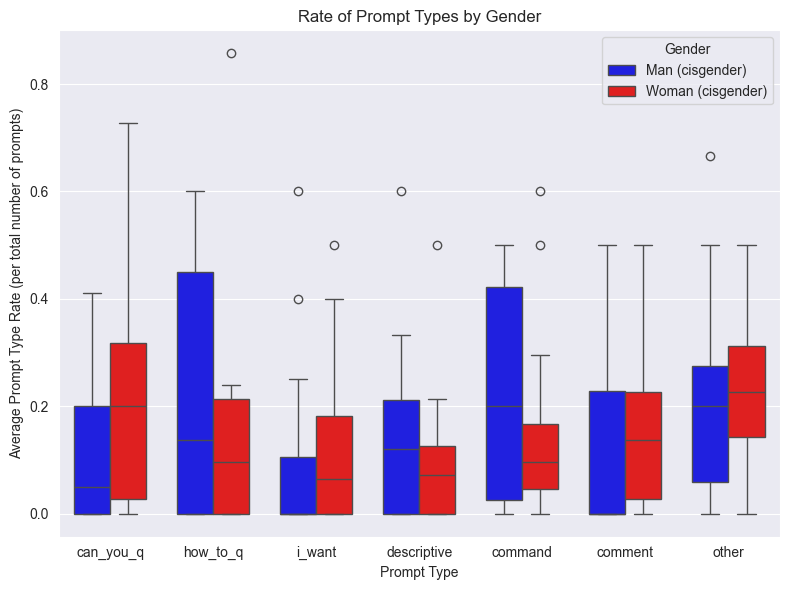

can_you_q:
  Female: n=13, variance=0.0492
  Male:   n=15, variance=0.0196
Normality test (Shapiro-Wilk) for can_you_q:
  Female: stat=0.8956, p-value=0.1165 (normal)
  Male:   stat=0.7940, p-value=0.0031 (not normal)
At least one of the distributions is not normal, so we cannot run a t-test.
Mann-Whitney U test: stat=66.5000, p-value=0.1502
how_to_q:
  Female: n=13, variance=0.0524
  Male:   n=15, variance=0.0537
Normality test (Shapiro-Wilk) for how_to_q:
  Female: stat=0.6659, p-value=0.0003 (not normal)
  Male:   stat=0.8346, p-value=0.0106 (not normal)
At least one of the distributions is not normal, so we cannot run a t-test.
Mann-Whitney U test: stat=112.0000, p-value=0.5117
i_want:
  Female: n=13, variance=0.0277
  Male:   n=15, variance=0.0322
Normality test (Shapiro-Wilk) for i_want:
  Female: stat=0.8133, p-value=0.0098 (not normal)
  Male:   stat=0.6622, p-value=0.0001 (not normal)
At least one of the distributions is not normal, so we cannot run a t-test.
Mann-Whitney U te

In [5]:
from helpers.statistical_tests import compare_genders
import matplotlib.pyplot as plt
import seaborn as sns

# "Melt" the DataFrame for seaborn
melted = user_means.melt(
    id_vars=['user_id', 'gender'],
    value_vars=columns,
    var_name='Prompt Type',
    value_name='Normalized Rate (per number of prompts)'
)

plt.figure(figsize=(8,6))
sns.boxplot(
    data=melted,
    x='Prompt Type',
    y='Normalized Rate (per number of prompts)',
    hue='gender',
    palette={'Woman (cisgender)': 'red', 'Man (cisgender)': 'blue'},
    width=0.7
)

plt.title('Rate of Prompt Types by Gender')
plt.ylabel('Average Prompt Type Rate (per total number of prompts)')
plt.xlabel('Prompt Type')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

for col in columns:
    compare_genders(user_means, col)

## Excluding zeros

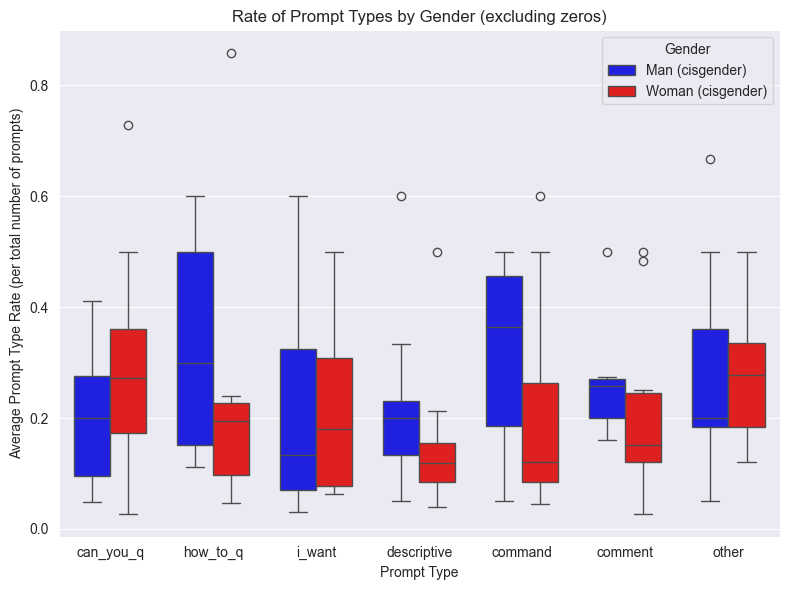

Test for can_you_q (zero-removed):
can_you_q:
  Female: n=10, variance=0.0440
  Male:   n=8, variance=0.0170
Normality test (Shapiro-Wilk) for can_you_q:
  Female: stat=0.9429, p-value=0.5862 (normal)
  Male:   stat=0.9380, p-value=0.5918 (normal)
Both distributions are normal, so we can run a t-test.
  T-statistic: -1.0653, p-value: 0.3034
------------------------------
Test for how_to_q (zero-removed):
how_to_q:
  Female: n=9, variance=0.0604
  Male:   n=10, variance=0.0417
Normality test (Shapiro-Wilk) for how_to_q:
  Female: stat=0.6544, p-value=0.0004 (not normal)
  Male:   stat=0.8480, p-value=0.0549 (normal)
At least one of the distributions is not normal, so we cannot run a t-test.
Mann-Whitney U test: stat=62.0000, p-value=0.1771
------------------------------
Test for i_want (zero-removed):
i_want:
  Female: n=8, variance=0.0265
  Male:   n=7, variance=0.0444
Normality test (Shapiro-Wilk) for i_want:
  Female: stat=0.8865, p-value=0.2170 (normal)
  Male:   stat=0.8715, p-valu

In [8]:
from statsmodels.stats.multitest import multipletests

user_means_no_zeros = user_means.copy()
user_means_no_zeros[columns] = user_means_no_zeros[columns].replace(0, np.nan)

melted = user_means_no_zeros.melt(
    id_vars=['user_id', 'gender'],
    value_vars=columns,
    var_name='Prompt Type',
    value_name='Normalized Rate (per number of prompts)'
)

# Seaborn/matplotlib will automatically ignore NaNs
plt.figure(figsize=(8,6))
sns.boxplot(
    data=melted,
    x='Prompt Type',
    y='Normalized Rate (per number of prompts)',
    hue='gender',
    palette={'Woman (cisgender)': 'red', 'Man (cisgender)': 'blue'},
    width=0.7
)
plt.title('Rate of Prompt Types by Gender (excluding zeros)')
plt.ylabel('Average Prompt Type Rate (per total number of prompts)')
plt.xlabel('Prompt Type')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

p_values = []
for col in columns:
    print(f"Test for {col} (zero-removed):")
    p_values.append((compare_genders(user_means_no_zeros, col)))
    print("-" * 30)

print(list(zip(columns, p_values)))
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
print(reject)

## Age Groups

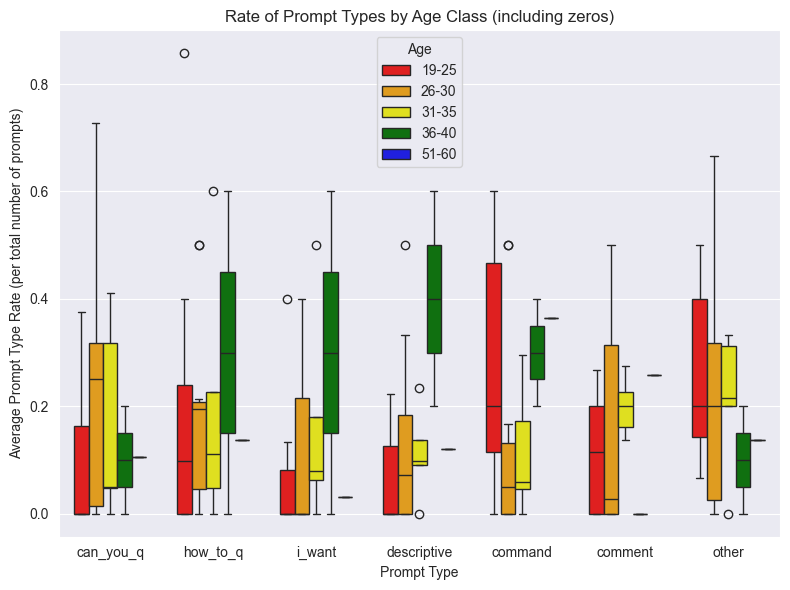

age
19-25     9
26-30    11
31-35     5
36-40     2
51-60     1
dtype: int64


In [30]:



melted = user_means.melt(
    id_vars=['user_id', 'age'],
    value_vars=columns,
    var_name='Prompt Type',
    value_name='Normalized Rate (per number of prompts)'
)

palette = {'19-25': 'red', '26-30': 'orange', '31-35': 'yellow', '36-40': 'green', '51-60': 'blue'}

plt.figure(figsize=(8,6))
sns.boxplot(
    data=melted,
    x='Prompt Type',
    y='Normalized Rate (per number of prompts)',
    hue='age',
    palette=palette,
    width=0.7
)
plt.title('Rate of Prompt Types by Age Class (including zeros)')
plt.ylabel('Average Prompt Type Rate (per total number of prompts)')
plt.xlabel('Prompt Type')
plt.legend(title='Age')
plt.tight_layout()
plt.show()

print(user_means.groupby('age').size())